# Product Recommender Using Multi-Armed Bandit Algorithms

In [1]:
# Import packages
import random
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
class Bandit:
    """A useful class containing the multi-armed bandit and all its actions.

    Attributes:
        actions The actions that can be performed, numbered automatically 0, 1, 2...
        payoff_probs    The underlying pay-off probabilities for each action.
    """

    def __init__(self, payoff_probs):
        self.actions = range(len(payoff_probs))
        self.payoff_probs = payoff_probs

    def sample(self, action):
        
        """Sample from the multi-armed by performing an action.

        Args:
            action (int): The action performed on the multi-armed bandit.
        Returns:
            int: It returns a reward based on that arm's pay-off probability.
        """
    
        selector = random.random()
        # We are going to keep it simple with 1 or 0 being the only rewards
        return 1 if selector <= self.payoff_probs[action] else 0

In [3]:
def random_agent(bandit, iterations):
    """Randomly select an action and reward."""

    for i in range(iterations):
        a = random.choice(bandit.actions)
        r = bandit.sample(a)
        yield a, r

In [4]:
def optimal_agent(bandit, iterations):
    """Select the best action by taking a sneak-peek at the bandit's probabilities."""

    for i in range(iterations):
        a = bandit.payoff_probs.index(max(bandit.payoff_probs))
        r = bandit.sample(a)
        yield a, r

In [5]:
def initial_explore_agent(bandit, iterations, initial_rounds=10):
    """
    Initially explore initial_rounds times and then stick to the best action.
    """
    pay_offs = dict()
    best_action = -1
    
    for i in range(iterations):
        # for the initial rounds pick a random action
        if i < initial_rounds:
            a = random.choice(bandit.actions)
            r = bandit.sample(a)
            
            # Update rewards
            if a in pay_offs:
                pay_offs[a].append(r)
            else:
                pay_offs[a] = [r]
        # otherwise pick the best one thus far
        else:
            if (best_action == -1):
                # check for the action with the best average payoff
                mean_dict = {}
                for key, val in pay_offs.items():
                    mean_dict[key] = np.mean(val)
                best_action = max(mean_dict, key=mean_dict.get)
            a = best_action
            r = bandit.sample(a)
        yield a, r

## Epsilon Greedy

The epsilon greedy algorithm allow you to only explore random actions with epsilon probability. Otherwise, with the probability of 1-epsilon, you pick the action with the best average payoff.

The reasoning behind this approach is that for a portion of the time the algorithm randomly explores the available actions, but it still exploits the best action the majority of the time.

In [6]:
def epsilon_greedy_agent(
        bandit,
        iteractions,
        epsilon=0.2,
        initial_rounds=1,
):
    """
    Use the epsilon-greedy algorithm by performing the actioon with the bset average payoff with the probability(1-epsilon), otherwise pick a random action to keep exploring.

    """

    pay_offs = dict()
    for i in range(iteractions):
        # Sometimes randomly pick an action to explore
        if random.random() < epsilon or i < initial_rounds:
            a = random.choice(bandit.actions)

        # otherwise pick the best one thus far
        else:
            new_dict = {}
            for key, val in pay_offs.items():
                new_dict[key] = np.mean(val)
            a = max(new_dict, key=new_dict.get)
        r = bandit.sample(a)

        # Update rewards
        if a in pay_offs:
            pay_offs[a].append(r)
        else:
            pay_offs[a] = [r]

        yield a, r

In [7]:
def decaying_epsilon_greedy_agent(bandit,
                         iteractions,
                         epsilon=0.2,
                         initial_rounds=1,
                         decay=0.99):
    """
    Use the decaying epsilon-greedy algorithm by performing the actioon with the bset average payoff with the probability(1-epsilon), otherwise pick a random action to keep exploring.
    
    """

    pay_offs = dict()
    for i in range(iteractions):
        # Sometimes randomly pick an action to explore
        if random.random() < epsilon or i < initial_rounds:
            a = random.choice(bandit.actions)

        # otherwise pick the best one thus far
        else:
            new_dict = {}
            for key, val in pay_offs.items():
                new_dict[key] = np.mean(val)
            a = max(new_dict, key=new_dict.get)
        r = bandit.sample(a)

        # Update rewards
        if a in pay_offs:
            pay_offs[a].append(r)
        else:
            pay_offs[a] = [r]

        epsilon *= decay

        yield a, r

random_agent : 48.795
initial_explore_agent : 65.159
epsilon_greedy_agent : 74.698
decaying_epsilon_greedy_agent : 73.715
optimal_agent : 100.301


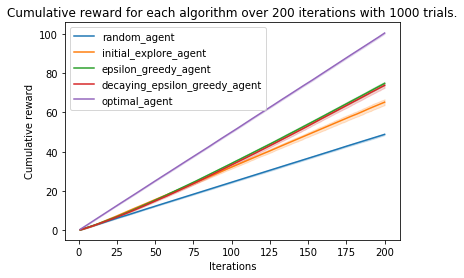

In [8]:
def main():
    random.seed(200) #used for reproducibility

    pay_offs = [0.25, 0.3, 0.5, 0.1, 0.3, 0.25, 0]
    bandit = Bandit(pay_offs)

    f = plt.figure()
    
    methods = [random_agent, initial_explore_agent, epsilon_greedy_agent, decaying_epsilon_greedy_agent, optimal_agent]

    number_of_iterations = 200
    number_of_trials = 1000

    for m in range(len(methods)):
        method = methods[m]
        total_rewards = []

        list_of_cumulative_rewards = []
        fan = []

        for trial in range(number_of_trials):
            total_reward = 0
            cumulative_reward = []

            for a, r in method(bandit, number_of_iterations):
                total_reward += r
                cumulative_reward.append(total_reward)


            #plt.plot(cumulative_reward, alpha=.02, color=colors[m])
            total_rewards.append(total_reward)

            if trial == 0:
                fan = pd.DataFrame(cumulative_reward, columns=['y'])
                fan['x'] = fan.index+1
            else:
                fan2 = pd.DataFrame(cumulative_reward, columns=['y'])
                fan2['x'] = fan2.index+1

                fan = fan.append(fan2, ignore_index=True)

            list_of_cumulative_rewards.append(cumulative_reward)

        sns.lineplot(x='x', y='y', data=fan)  #default is to use bootstrap to calculate confidence interval     
        
        print(method.__name__, ":", np.mean(total_rewards))

    plt.title("Cumulative reward for each algorithm over {} iterations with {} trials.".format(number_of_iterations, number_of_trials))
    plt.ylabel("Cumulative reward")
    plt.xlabel("Iterations")
    plt.legend([method.__name__ for method in methods])
    
    f.savefig("./tmp/Iterations.pdf", bbox_inches='tight')
    f.savefig("./tmp/Iterations.svg", bbox_inches='tight')

    plt.show()

if __name__ == "__main__":
    main()
